In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
from  sklearn.linear_model import LogisticRegression


In [32]:
import seaborn as sns

In [5]:
test_data = pd.read_csv('titanic_test.csv')

In [6]:
train_data = pd.read_csv('titanic_train.csv')

### Data Exploration


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 11 columns):
Pclass      668 non-null int64
Name        668 non-null object
Sex         668 non-null object
Age         536 non-null float64
SibSp       668 non-null int64
Parch       668 non-null int64
Ticket      668 non-null object
Fare        668 non-null float64
Cabin       154 non-null object
Embarked    667 non-null object
Survived    668 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 57.5+ KB


In [9]:
train_data.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,668.000000,536.000000,668.000000,668.000000,668.000000,668.000000
mean,2.296407,29.700560,0.528443,0.407186,32.064552,0.402695
std,0.831638,14.240257,1.080327,0.854695,45.320835,0.490808
min,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.925000,0.000000
50%,3.000000,29.000000,0.000000,0.000000,14.750000,0.000000
75%,3.000000,38.250000,1.000000,0.000000,31.275000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [10]:
train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.000,NaN,S,1
1,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.050,NaN,S,0
2,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.000,NaN,S,0
3,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,0
4,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.050,NaN,S,0


### Detailed look at what data is missing 

In [25]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent1 = (train_data.isnull().sum()/len(train_data))*100
percent2 = round(percent1,1).sort_values(ascending= False)
missing_data = pd.concat([total,percent2],axis = 1,keys = ['Total','Percentage'])
missing_data

,Total,Percentage
Cabin,514,76.9
Age,132,19.8
Embarked,1,0.1
Survived,0,0.0
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0
SibSp,0,0.0
Sex,0,0.0
Name,0,0.0


In [29]:
train_data.columns.values

array(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Survived'], dtype=object)

### Feature that could contribute to a high survival rate:

Text(0.5, 1.0, 'Men')

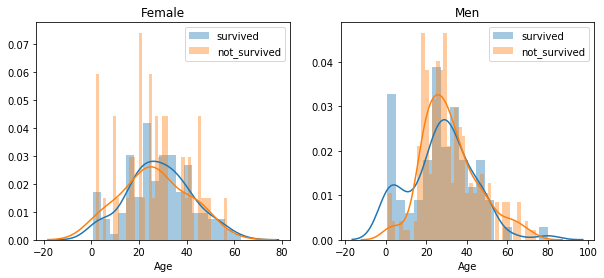

In [36]:
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize = (10,4))

women = train_data[train_data['Sex']== 'female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']== 1].Age.dropna(),bins = 18,label = 'survived',ax=axes[0])
ax = sns.distplot(women[women['Survived']==0].Age.dropna(),bins = 40,label= 'not_survived',ax= axes[0])
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(),bins = 18,label = 'survived',ax=axes[1])
ax = sns.distplot(men[men['Survived']==0].Age.dropna(),bins = 40 ,label= 'not_survived',ax = axes[1])
ax.legend()
ax.set_title('Men')

### P- Class

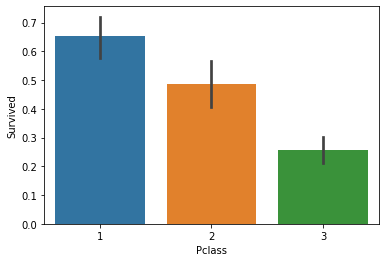

In [38]:
sns.barplot(x = 'Pclass',y = 'Survived',data = train_data)

### SibSp and Parch:


In [41]:
data = [train_data,test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp']+dataset['Parch']
    dataset.loc[dataset['relatives']>0,'alone'] = 0
    dataset.loc[dataset['relatives']==0,'alone']=1
    dataset['alone'] = dataset['alone'].astype(int)
train_data['alone'].value_counts()

1    392
0    276
Name: alone, dtype: int64

### if someone is alone :

In [43]:
train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,relatives,alone
0,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.000,NaN,S,1,1,0
1,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.050,NaN,S,0,0,1
2,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.000,NaN,S,0,0,1
3,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,0,4,0
4,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.050,NaN,S,0,0,1


## Handling the missing data

### CABIN

In [48]:
import re 
deck = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'U':8}
data = [train_data,test_data]
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck) 
    dataset['Deck'].fillna(0,inplace = True )
    dataset['Deck']= dataset['Deck'].astype(int)
    

In [50]:
train_data.drop(['Cabin'],axis = 1,inplace = True)

In [52]:
test_data.drop(['Cabin'],axis = 1,inplace = True)

### AGE

In [59]:
data = [train_data,test_data]
for dataset in data:
    mean = train_data['Age'].mean()
    std = train_data['Age'].std()
    is_null = train_data['Age'].isnull().sum()
    # computing random numbers between mean, std and null values 
    rand_age = np.random.randint(mean-std,mean+std,size = is_null)
    
    
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice
    dataset['Age']= dataset['Age'].astype(int)
train_data.Age.isnull().sum()

0

### Embarked 

In [61]:
train_data.Embarked.describe()

count     667
unique      3
top         S
freq      484
Name: Embarked, dtype: object

In [130]:
common_value = 'S'
data = [train_data,test_data]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## Converting Features:

In [77]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 13 columns):
Pclass       668 non-null int64
Name         668 non-null object
Sex          668 non-null object
Age          668 non-null int32
SibSp        668 non-null int64
Parch        668 non-null int64
Ticket       668 non-null object
Fare         668 non-null float64
Embarked     668 non-null object
Survived     668 non-null int64
relatives    668 non-null int64
alone        668 non-null int32
Deck         668 non-null int32
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 60.1+ KB


In [78]:
# Fare --> int
data=[train_data,test_data]
for dataset in data:
    dataset['Fare']=dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [97]:
# now will extract titles from the names 
data = [train_data,test_data]
titles = {'Mr':1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
for dataset in data:
    #extract titles
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.',expand = False)
    # replace titles with more common title or as RARE
    dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare',inplace = True)
    dataset['Title'].replace('Mile','Miss')
    dataset['Title'].replace('Ms','Miss')
    dataset['Title'].replace('Mme','Mrs')
    # convert titles into numbers 
    dataset['Title'] = dataset['Title'].map(titles)
    # filling nan with 0 to be safe
    dataset['Title'].fillna(0,inplace = True)

    

In [99]:
train_data.drop(['Name'],axis = 1,inplace = True)
test_data.drop(['Name'],axis = 1,inplace = True)

In [100]:
## sex
genders = {'male':0,'female':1}
data = [train_data,test_data]
for dataset in data:
    dataset['Sex']= dataset['Sex'].map(genders)

In [102]:
#TicketsSince the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them 
#into useful categories. So we will drop it from the dataset.

train_data = train_data.drop(['Ticket'],axis = 1)
test_data  = test_data.drop(['Ticket'],axis=1)

In [132]:
#Embarke 
ports = {'S':0,'C':1,'Q':'2'}
data = [train_data,test_data]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Creating Categories

In [105]:
data = [train_data,test_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age']<=11,'Age']=0
    dataset.loc[(dataset['Age']>11)&(dataset['Age']<=18),'Age']=1
    dataset.loc[(dataset['Age']>18)&(dataset['Age']<=22),'Age']=2
    dataset.loc[(dataset['Age']>22) &(dataset['Age']<=27),'Age']=3
    dataset.loc[(dataset['Age']>27) &(dataset['Age']<=33),'Age']=4
    dataset.loc[(dataset['Age']>33) &(dataset['Age']<=40),'Age']=5
    dataset.loc[(dataset['Age']>40) &(dataset['Age']<=66),'Age']=6
    dataset.loc[dataset['Age']>66,'Age']=6
train_data.Age.value_counts()

4    127
6    119
5    117
3    109
2     80
1     67
0     49
Name: Age, dtype: int64

In [106]:
#Fare
data = [train_data,test_data]

for dataset in data:
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare']=1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## Creataing New Features

In [108]:
#1 Age,Time - Class
data= [train_data,test_data]
for dataset in data:
    dataset['Age_Class'] = dataset['Age']*dataset['Pclass']

In [110]:
# Fare per person
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [111]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,relatives,alone,Deck,Title,Age_Class,Fare_Per_Person
0,2,1,4,1,0,2,0,1,1,0,8,3.0,8,1
1,3,0,3,0,0,1,0,0,0,1,8,1.0,9,1
2,2,0,5,0,0,2,0,0,0,1,8,1.0,10,2
3,3,1,4,0,4,2,0,0,4,0,8,3.0,12,0
4,3,0,3,0,0,0,0,0,0,1,8,1.0,9,0


## Deploying Logistic Regression:

In [112]:
X_train = train_data.drop(['Survived'],axis=1)
Y_train = train_data['Survived']

In [114]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,alone,Deck,Title,Age_Class,Fare_Per_Person
0,2,1,4,1,0,2,0,1,0,8,3.0,8,1
1,3,0,3,0,0,1,0,0,1,8,1.0,9,1
2,2,0,5,0,0,2,0,0,1,8,1.0,10,2
3,3,1,4,0,4,2,0,4,0,8,3.0,12,0
4,3,0,3,0,0,0,0,0,1,8,1.0,9,0


In [135]:
X_test = test_data.copy()

In [136]:
algo = LogisticRegression()
algo.fit(X_train,Y_train)

C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
Y_pred = algo.predict(X_test)

In [138]:
log_score = round(algo.score(X_train,Y_train)*100,2)

In [139]:
log_score

81.14

In [140]:
Y_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0], dtype=int64)